<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/generate_DS_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inizializzation.

This Cell download and intstall ROOT in python 2 environment. 

Runs this part of the script only when you have to init a new machine e and working space

In [2]:
# istallazione di ROOT dal CERN
!mkdir -p APPS
!pwd
!cd APPS && wget --no-check-certificate https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
!cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

base_lib_path = '/content/APPS/root/lib/'
# main paths for ROOT  
import sys
sys.path.append(base_lib_path)
import ctypes
sys.path.append(base_lib_path)
ctypes.cdll.LoadLibrary(base_lib_path+'libCore.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libThread.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libImt.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libRIO.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libNet.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libTree.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libMathCore.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libMatrix.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libHist.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libGraf.so')
# itsllation and root-numpy main PATH
!pip install root-numpy
ctypes.cdll.LoadLibrary(base_lib_path+'libMultiProc.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libGpad.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libGraf3d.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libTreePlayer.so')
# patch to open online FILE
! sudo apt-get install libdavix0v5
ctypes.cdll.LoadLibrary(base_lib_path+'libRDAVIX.so')
! echo "Davix.GSI.CACheck: n" >> $ROOTSYS/etc/system.rootrc
! cp $ROOTSYS/etc/system.rootrc $HOME/.rootrc
! tail -1 $HOME/.rootrc
! pip install -q  python-swiftclient
! pip install -q  keystoneauth1
! pip install -q  h5py
! rm cygnus_lib.*; rm mylib.*
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
sys.path.append('.')
! mkdir -p data

/content
--2020-06-19 09:10:43--  https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz
Resolving root.cern.ch (root.cern.ch)... 137.138.13.143, 2001:1458:201:45::100:b
Connecting to root.cern.ch (root.cern.ch)|137.138.13.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137415272 (131M) [application/x-gzip]
Saving to: ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz’

root_v6.13.08.Linux 100%[===================>] 131.05M  10.9MB/s    in 14s     

2020-06-19 09:10:59 (9.20 MB/s) - ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz’ saved [137415272/137415272]

     |████████████████████████████████| 522kB 2.8MB/s 
  Created wheel for root-numpy: filename=root_numpy-4.8.0-cp27-cp27mu-linux_x86_64.whl size=1075547 sha256=378747011c4012ba820f7a7756528a479aef848a692822c3d4346a7a3f551c9d
  Stored in directory: /root/.cache/pip/wheels/f0/3c/18/62ccf3aec0284175916617d699f179d7cdbe4de0c7070be2a5
Successfully built root-numpy
Reading pack

This Cell Load funcions (libraries) to retrive data from swift CYGNO server

Runs this part of the script only when you have to init a new machine e and working space

In [3]:
import sys
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp

import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

x_resolution = y_resolution = 2048
cy.set_atlas_style('square')


Welcome to JupyROOT 6.13/08


Generate data stream file looking for close clusters in any images: 

1.   download pedestal file [run_ped]
2.   download dafa file/s [runI] from specifc location [dataSelection]
3.   Serch for cluster with DBSCAN
4.   save output in txt file


In [ ]:
runI          = [2098] 
run_ped       = 2054 
cimax         = 300
cimin         = 0 
dataSelection = 'LAB'
rescale       = 512
nsigma        = 1.5


try:
  fh5 = ("run%d_mean.h5" % (run_ped))
  cmd = 'wget -nv https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
  os.system(cmd)
  fh5 = ("run%d_sigma.h5" % (run_ped))
  cmd = 'wget -nv https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
  os.system(cmd)
except:
  print ("No Pedestal file for run %s on remote repo" % run_ped)
  print ("STOP")
  sys.exit(1)

#########################

try:
  fileoutm = ("./data/run%d_mean.h5" % (run_ped))
  m_image = cy.read_image_h5(fileoutm)
  PedOverMax = m_image[m_image > cimax].size
  print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
    (m_image[m_image<cimax].mean(), 
    np.sqrt(m_image[m_image<cimax].var()), cimax,
    (m_image>cimax).sum()))
except:
  print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run_ped)
  print ("STOP")
  sys.exit(1)
 
try: 
  fileouts = ("./data/run%d_sigma.h5" % (run_ped))
  s_image = cy.read_image_h5(fileouts)
  print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
    (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
  print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run_ped)
  print ("STOP")
  sys.exit(1)

#########################

th_image   = np.round(m_image + nsigma*s_image)
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))
    
for nRi in range(len(runI)):
  try:
    print ('Open file: '+cy.swift_root_file(dataSelection, runI[nRi]))
    f = ROOT.TFile.Open(cy.swift_root_file(dataSelection, runI[nRi]))

    print ('Find Keys: '+str(len(f.GetListOfKeys())))
    pic, wfm = cy.root_TH2_name(f)
    max_image = len(pic)
    max_wfm = len(wfm)
    print ("# of Images (TH2) Files: %d " % (max_image))
    print ("# of Waveform (TH2) Files: %d " % (max_wfm))
    nImag=max_image
  except:
    print ("ERROR: No file %d" % (runI[nRi]))
    break
  # data_to_save = []
  # files = ("./data/dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d_ped_%d.txt" % 
  #                 (runI[nRi], cimin, cimax, rescale, nsigma, max_image, run_ped))

  df = pd.DataFrame(columns = ["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"])

  file_out = ("./data/dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d_ped_%d.plk.gz" % 
                    (runI[nRi], cimin, cimax, rescale, nsigma, max_image, run_ped))
  for iTr in range(0, max_image):
    if iTr % 10 == 0: 
      # running & debug ...
      print ('Processing RUN: ', runI[nRi], 'Event: ', iTr)

      # end 

    image = rtnp.hist2array(f.Get(pic[iTr])).T

    rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
    rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))

    edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
    points          = np.array(np.nonzero(edges)).T.astype(float) 
    scaler          = StandardScaler()
    # X_scaled        = scaler.fit_transform(points)
    ########### if 3D #############
    points_3d = []
    for j in range(len(points)):
      x = points[j,0]
      y = points[j,1]
      z = rebin_image[int(y),int(x)]
      points_3d.append([y,x,z]) 
    
    X_scaled        = StandardScaler().fit_transform(points_3d)
    # #######################
    dbscan          = DBSCAN(eps=0.2, min_samples = 30)
    dbscan.fit(points_3d)

    clusters = dbscan.fit_predict(X_scaled)

    for ic in range (min(dbscan.labels_), max(dbscan.labels_)):
        ph = 0.
        # print ("value: ", iTr, ic, dbscan.labels_[ic], min(dbscan.labels_), max(dbscan.labels_))
        yc = points[:,1][dbscan.labels_==ic]
        xc = points[:,0][dbscan.labels_==ic]
        ph, dim = cy.cluster_par(yc, xc, rebin_image)
        width, height, pearson = cy.confidence_ellipse_par(yc,xc)
        for j in range(0, dim):
            x=int(xc[j])
            y=int(yc[j])
            #ph += rebin_image[y,x]
            if j == 0:
                x0start = x
                y0start = y
        x0end = x
        y0end = y
        df = df.append({"iTr":iTr, "cluster_lable":ic, "pixels":dim, "photons":ph, "ph_pixels":ph/dim, "x0start":x0start, "y0start":y0start, 
          "x0end":x0end, "y0end":y0end, "width":width, "height":height, "pearson":pearson},
                       ignore_index=True)
        # data_to_save.append([iTr, ic, dim, ph, ph/dim, 
        #                       x0start, y0start, x0end, y0end, width, height, pearson])
      
  # np.savetxt(files, data_to_save, fmt='%.10e', delimiter=" ")
  df.to_pickle(file_out, compression='gzip')
  print ("out file", files)

Pedestal mean: 99.57, sigma: 0.91, over th. (300) 9
Sigma mean: 2.52, sigma: 2.14, over th. (50) 7
light over Th: 15841590.89 
Open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run02098.root
Find Keys: 2006
# of Images (TH2) Files: 1003 
# of Waveform (TH2) Files: 1003 
('Processing RUN: ', 2098, 'Event: ', 0)
('Processing RUN: ', 2098, 'Event: ', 10)
('Processing RUN: ', 2098, 'Event: ', 20)
('Processing RUN: ', 2098, 'Event: ', 30)
('Processing RUN: ', 2098, 'Event: ', 40)
('Processing RUN: ', 2098, 'Event: ', 50)
('Processing RUN: ', 2098, 'Event: ', 60)
('Processing RUN: ', 2098, 'Event: ', 70)
('Processing RUN: ', 2098, 'Event: ', 80)
('Processing RUN: ', 2098, 'Event: ', 90)
('Processing RUN: ', 2098, 'Event: ', 100)
('Processing RUN: ', 2098, 'Event: ', 110)
('Processing RUN: ', 2098, 'Event: ', 120)
('Processing RUN: ', 2098, 'Event: ', 130)
('Processing RUN: ', 2098, 'Event: ', 140)
('Processing RUN: ', 2098, 'Event

In [ ]:
# outputs (.h5 are the pedestal files)
!ls data

da fare:
1.   studiarsi DBSCAN e come vengono selzionati i dati
2.   mostrare il risultato di cluserizzazione di DBSCAN su ogni imagine (fare un debug delo script mostrando le immagini)
2.   con panda caricare i file di output
2.   guardarsi le varie variabili, visualizzarli, capire che significano
3.   fare la distribuzione del numero di fotoni
4.   fittarla con un esponenziale (coda del fondo) piu' gaussina (picco dei fotoni)
5.   studiare l'andamento del picco del ferro nel tempo per i run pari tra 1856 e 2031





In [4]:
def TGraph2array(tgraph):
  xl = []; yl = []
  for i in range(tgraph.GetN()):
      xi = ctypes.c_double(); yi = ctypes.c_double()
      tgraph.GetPoint(i,xi,yi)
      xl.append(xi.value)
      yl.append(yi.value)
  x = np.array(xl)
  y = np.array(yl)
  return x, y

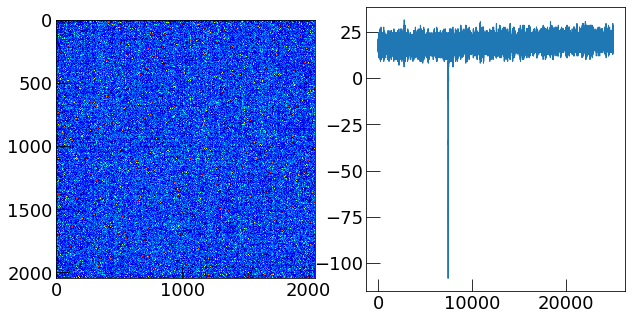

In [6]:
# mostra l'immagine iTr del file ...

iTr = 5
#
f  = ROOT.TFile.Open('https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run01856.root');
#f  = ROOT.TFile.Open('https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/TES/run01.root')
pic, wfm = cy.root_TH2_name(f)
if len(wfm):
  fig, ax = plt.subplots (1,2, figsize=(10,5))
else:
  fig, ax = plt.subplots (1, figsize=(10,10))
#

image = rtnp.hist2array(f.Get(pic[iTr])).T
if len(wfm):
  ax[0].imshow(image,  cmap="jet", vmin=95,vmax=120)
  t,a = TGraph2array(f.Get(wfm[iTr]))
  ax[1].plot(t,a) 
else:
  plt.imshow(image,  cmap="jet", vmin=95,vmax=120)

plt.show()

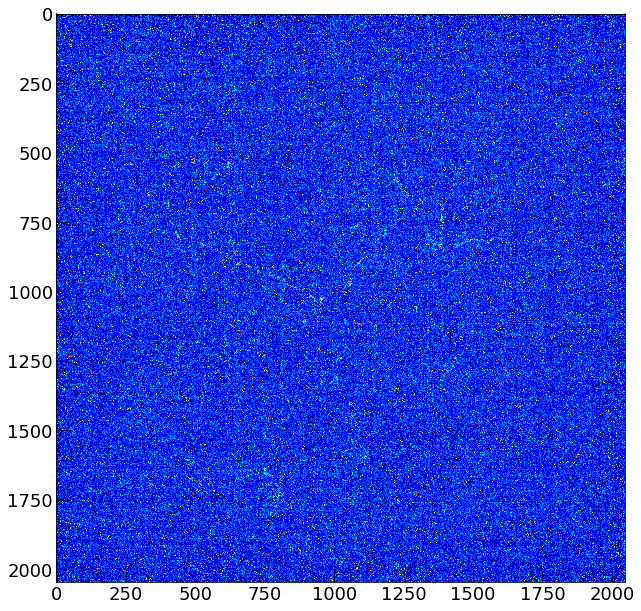

None

In [12]:
# mostra una sequenza di imagini e tracce dell'oscilloscopio
from IPython import display
def TGraph2array(tgraph):
  xl = []; yl = []
  for i in range(tgraph.GetN()):
      xi = ctypes.c_double(); yi = ctypes.c_double()
      tgraph.GetPoint(i,xi,yi)
      xl.append(xi.value)
      yl.append(yi.value)
  x = np.array(xl)
  y = np.array(yl)
  return x, y
# mostra l'immagine iTr del file ... al volo (non possibile sula cloud ora)

cy.set_atlas_style('long')
f  = ROOT.TFile.Open('https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run01856.root');
f  = ROOT.TFile.Open('https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/TES/run01.root')
pic, wfm = cy.root_TH2_name(f)

max_image = len(pic)
max_wfm = len(wfm)
for iTr in range(0, max_image):
    try:
        if len(wfm):
          fig, ax = plt.subplots (1,2, figsize=(10,5))
        else:
          fig, ax = plt.subplots (1, figsize=(10,10))
        pic, wfm = cy.root_TH2_name(f)
        #
        image = rtnp.hist2array(f.Get(pic[iTr])).T
        if len(wfm):
          ax[0].imshow(image,  cmap="jet", vmin=95,vmax=120)
          t,a = TGraph2array(f.Get(wfm[iTr]))
          ax[1].plot(t,a) 
        else:
          plt.imshow(image,  cmap="jet", vmin=95,vmax=120)

        display.display(plt.show())
        display.clear_output(wait=True)
        raw_input("Press Enter to continue...")
    except KeyboardInterrupt:
        break

In [ ]:
# scarica localemete il file HIS
! wget 'https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/TES/run821.HIS'
# ! wget 'https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/TES/lime/secondo_460_2.5.HIS'

In [ ]:
# convetre il file HIS in ROOT oppure, lavora direttamente sul file HIS cariccando l'immagine
his_file = './run821.HIS' 
# his_file = 'secondo_460_2.5.HIS'
his = cy.openHIS(his_file) # apre il file HIS
fname = os.path.basename(his_file).split('.')[-2]
for idx, section in enumerate(his):
    print (idx)
    img = np.array(section, dtype=np.ushort)
    #### se serve fa il file ROOT
    #option = 'recreate' if idx==0 else 'update'
    #cy.write2root(fname, img, idx, option)
    ### se serve mostra le imagini del file HIS
    plt.imshow(img, vmin=95, vmax=110, cmap='jet')
    plt.show()

In [ ]:
!ls -lh